https://www.kaggle.com/c/competitive-data-science-final-project

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

In [3]:
path = '/Users/rizki/Dropbox/Coursera/AML_HowToKaggle/FinalProject/PredictSales/all/'

items = pd.read_csv(path+'items.csv')
item_categories = pd.read_csv(path+'item_categories.csv')
shops = pd.read_csv(path+'shops.csv')
sales_train = pd.read_csv(path+'sales_train.csv')
test = pd.read_csv(path+'test.csv')

# Format 'date' to datetime
sales_train['date'] = pd.to_datetime(sales_train['date'],format='%d.%m.%Y')

# Add item_category_id to sales_train
sales_train = pd.merge(sales_train,items[['item_id','item_category_id']],on='item_id',how='left').sort_values(by='item_id')

#add new columns: years, month, Y_M
sales_train['year'] = sales_train['date'].dt.year
sales_train['month'] = sales_train['date'].dt.month
sales_train_year = sales_train['date'].dt.year.astype('string')
sales_train_month = sales_train['date'].dt.month.astype('string')
sales_train['Y_M'] = sales_train_year+'_'+sales_train_month

#split by year
sales_2013 = sales_train[sales_train['year']==2013]
sales_2014 = sales_train[sales_train['year']==2014]
sales_2015 = sales_train[sales_train['year']==2015]

In [4]:
#columns to keep
#col_to_keep = ['shop_id','item_id','item_price','item_category_id','item_cnt_day']
col_to_keep = ['shop_id','item_id','item_category_id','item_cnt_day']

groupby_list = ['shop_id','item_id']

#agg_dict = {'item_price':'mean','item_category_id':'mean','item_cnt_day':'sum'}
agg_dict = {'item_category_id':'mean','item_cnt_day':'sum'}
agg_targ = {'item_cnt_day':'sum'}

In [28]:
########### switches ########

saveplots=False
saveName='Oct10-2018_1'
createSubmit = False

#feature options
lag_length = 5
diff = True
diffRel = False
item_cat_count_feat= False

##############################

# create train/val/test set

In [29]:
### training set : 11-2013 with lag features 

x_train = sales_2013[sales_2013['month']==11]
x_train = x_train[col_to_keep]

#Target features:
#agg shop_item 
x_train_shop_item = x_train.groupby(groupby_list,as_index=False).agg(agg_dict).rename(columns={'item_cnt_day':'shop_item_cnt_month'})
#agg shop 
x_train_shop = x_train[['shop_id','item_cnt_day']].groupby(['shop_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'shop_cnt_month'})
#agg item 
x_train_item = x_train[['item_id','item_cnt_day']].groupby(['item_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'item_cnt_month'})
#agg item_cat 
if(item_cat_count_feat):x_train_itemcat = x_train[['item_category_id','item_cnt_day']].groupby(['item_category_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'item_cat_cnt_month'})


#introduce lag features 10 months behind.
for i in xrange(1,lag_length+1):
    x_train_lag = sales_2013[sales_2013['month']==(11-i)]
    x_train_lag = x_train_lag[col_to_keep]

    #agg shop_item 
    x_train_shop_item_lag = x_train_lag.groupby(groupby_list,as_index=False).agg(agg_dict).rename(columns={'item_cnt_day':'shop_item_cnt_month_lag_'+str(i)})
    x_train_shop_item_lag.drop(columns=['item_category_id'],inplace=True)
    #agg shop 
    x_train_shop_lag = x_train_lag[['shop_id','item_cnt_day']].groupby(['shop_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'shop_cnt_month_lag_'+str(i)})
    #agg item 
    x_train_item_lag = x_train_lag[['item_id','item_cnt_day']].groupby(['item_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'item_cnt_month_lag_'+str(i)})
    #agg item_cat 
    if(item_cat_count_feat):x_train_itemcat_lag = x_train_lag[['item_category_id','item_cnt_day']].groupby(['item_category_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'item_cat_cnt_month_lag_'+str(i)})

    #merge
    x_train_shop_item = pd.merge(x_train_shop_item,x_train_shop_item_lag,on=['shop_id','item_id'],how='left')
    x_train_shop_item = pd.merge(x_train_shop_item,x_train_shop_lag,on=['shop_id'],how='left')
    x_train_shop_item = pd.merge(x_train_shop_item,x_train_item_lag,on=['item_id'],how='left')
    if(item_cat_count_feat):x_train_shop_item = pd.merge(x_train_shop_item,x_train_itemcat_lag,on=['item_category_id'],how='left')
    
    #diffs
    if i<2: continue
    for col in ['shop_item','shop','item','item_cat']:
        if(not item_cat_count_feat and col=='item_cat'): continue #skip item_cat if this feat is not turned on 
        if(diff):x_train_shop_item[col+'_cnt_month_diff({}-{})'.format(str(i-1),str(i))] = x_train_shop_item[col+'_cnt_month_lag_'+str(i-1)] - x_train_shop_item[col+'_cnt_month_lag_'+str(i)]   
        if(diffRel):x_train_shop_item[col+'_cnt_month_({}-{})/{}'.format(str(i-1),str(i),str(i))] = x_train_shop_item[col+'_cnt_month_diff({}-{})'.format(str(i-1),str(i))] / (x_train_shop_item[col+'_cnt_month_lag_'+str(i)]+1e-7)   
                   
y_train = x_train_shop_item['shop_item_cnt_month']
x_train = x_train_shop_item.drop(columns=['shop_item_cnt_month'])

x_train = x_train.fillna(0)

print 'x_train.shape :',x_train.shape
x_train.head()

y_train.head()

### validation set: 11-2014 with lag features

x_val = sales_2014[sales_2014['month']==11]
x_val = x_val[col_to_keep]

#agg shop_item 
x_val_shop_item = x_val.groupby(groupby_list,as_index=False).agg(agg_dict).rename(columns={'item_cnt_day':'shop_item_cnt_month'})
#agg shop 
x_val_shop = x_val[['shop_id','item_cnt_day']].groupby(['shop_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'shop_cnt_month'})
#agg item 
x_val_item = x_val[['item_id','item_cnt_day']].groupby(['item_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'item_cnt_month'})
#agg item_cat 
if(item_cat_count_feat):x_val_itemcat = x_val[['item_category_id','item_cnt_day']].groupby(['item_category_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'item_cat_cnt_month'})

#introduce lag features
for i in xrange(1,lag_length+1):
    x_val_lag = sales_2014[sales_2014['month']==(11-i)]
    x_val_lag = x_val_lag[col_to_keep]

    #agg shop_item 
    x_val_shop_item_lag = x_val_lag.groupby(groupby_list,as_index=False).agg(agg_dict).rename(columns={'item_cnt_day':'shop_item_cnt_month_lag_'+str(i)})
    x_val_shop_item_lag.drop(columns=['item_category_id'],inplace=True)
    #agg shop 
    x_val_shop_lag = x_val_lag[['shop_id','item_cnt_day']].groupby(['shop_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'shop_cnt_month_lag_'+str(i)})
    #agg item 
    x_val_item_lag = x_val_lag[['item_id','item_cnt_day']].groupby(['item_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'item_cnt_month_lag_'+str(i)})
    #agg item_cat 
    if(item_cat_count_feat):x_val_itemcat_lag = x_val_lag[['item_category_id','item_cnt_day']].groupby(['item_category_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'item_cat_cnt_month_lag_'+str(i)})

    #merge
    x_val_shop_item = pd.merge(x_val_shop_item,x_val_shop_item_lag,on=['shop_id','item_id'],how='left')
    x_val_shop_item = pd.merge(x_val_shop_item,x_val_shop_lag,on=['shop_id'],how='left')
    x_val_shop_item = pd.merge(x_val_shop_item,x_val_item_lag,on=['item_id'],how='left')
    if(item_cat_count_feat):x_val_shop_item = pd.merge(x_val_shop_item,x_val_itemcat_lag,on=['item_category_id'],how='left')
    
    #diffs
    if i<2: continue
    for col in ['shop_item','shop','item','item_cat']:
        if(not item_cat_count_feat and col=='item_cat'): continue #skip item_cat if this feat is not turned on 
        if(diff):x_val_shop_item[col+'_cnt_month_diff({}-{})'.format(str(i-1),str(i))] = x_val_shop_item[col+'_cnt_month_lag_'+str(i-1)] - x_val_shop_item[col+'_cnt_month_lag_'+str(i)]   
        if(diffRel):x_val_shop_item[col+'_cnt_month_({}-{})/{}'.format(str(i-1),str(i),str(i))] = x_val_shop_item[col+'_cnt_month_diff({}-{})'.format(str(i-1),str(i))] / (x_val_shop_item[col+'_cnt_month_lag_'+str(i)]+1e-7)   


y_val = x_val_shop_item['shop_item_cnt_month']
x_val = x_val_shop_item.drop(columns=['shop_item_cnt_month'])

x_val = x_val.fillna(0)

print 'x_val.shape :',x_val.shape
x_val.head()

y_val.head()

### test set: 11-2015 with lag features 

x_test = test.sort_values(by=groupby_list)

#add item_category_id.
x_test = pd.merge(x_test,items[['item_id','item_category_id']],on='item_id',how='left')

#introduce lag features
for i in xrange(1,lag_length+1):
    x_test_lag = sales_2015[sales_2015['month']==(11-i)]
    x_test_lag = x_test_lag[col_to_keep]

    #agg shop_item 
    x_test_shop_item_lag = x_test_lag.groupby(groupby_list,as_index=False).agg(agg_dict).rename(columns={'item_cnt_day':'shop_item_cnt_month_lag_'+str(i)})
    x_test_shop_item_lag.drop(columns=['item_category_id'],inplace=True)
    #agg shop 
    x_test_shop_lag = x_test_lag[['shop_id','item_cnt_day']].groupby(['shop_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'shop_cnt_month_lag_'+str(i)})
    #agg item 
    x_test_item_lag = x_test_lag[['item_id','item_cnt_day']].groupby(['item_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'item_cnt_month_lag_'+str(i)})
    #agg item_cat 
    if(item_cat_count_feat):x_test_itemcat_lag = x_test_lag[['item_category_id','item_cnt_day']].groupby(['item_category_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'item_cat_cnt_month_lag_'+str(i)})

    #merge
    x_test = pd.merge(x_test,x_test_shop_item_lag,on=['shop_id','item_id'],how='left')
    x_test = pd.merge(x_test,x_test_shop_lag,on=['shop_id'],how='left')
    x_test = pd.merge(x_test,x_test_item_lag,on=['item_id'],how='left')
    if(item_cat_count_feat):x_test = pd.merge(x_test,x_test_itemcat_lag,on=['item_category_id'],how='left')
    
    #diffs
    if i<2: continue
    for col in ['shop_item','shop','item','item_cat']:
        if(not item_cat_count_feat and col=='item_cat'): continue #skip item_cat if this feat is not turned on 
        if(diff):x_test[col+'_cnt_month_diff({}-{})'.format(str(i-1),str(i))] = x_test[col+'_cnt_month_lag_'+str(i-1)] - x_test[col+'_cnt_month_lag_'+str(i)]   
        if(diffRel):x_test[col+'_cnt_month_({}-{})/{}'.format(str(i-1),str(i),str(i))] = x_test[col+'_cnt_month_diff({}-{})'.format(str(i-1),str(i))] / (x_test[col+'_cnt_month_lag_'+str(i)]+1e-7)   


x_test = x_test.fillna(0)
x_test.drop(columns=['ID'],inplace=True)

print 'x_test.shape :',x_test.shape

x_train.shape : (51460, 30)
x_val.shape : (45755, 30)
x_test.shape : (214200, 30)


In [30]:
#combine 2013+2014
# x_train  = pd.concat([x_train, x_val], ignore_index=True)
# y_train  = pd.concat([y_train, y_val], ignore_index=True)
# x_train.shape

# Model training

In [32]:
### Boosted Decision Tree (lightgbm)

import lightgbm as lgb
from sklearn.metrics import r2_score

evals_result={}

lgb_train = lgb.Dataset(x_train, label=y_train)
lgb_test = lgb.Dataset(x_val, label=y_val)

lgb_params = {
               'feature_fraction': 1.00,
               'metric': 'rmse',
               'nthread':4, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75,#0.75 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':1
              }

num_boost_round = 2000
verbose_eval = num_boost_round/20
model = lgb.train(lgb_params, 
                  lgb_train,
                  valid_sets=[lgb_train, lgb_test],
                  valid_names=['train','eval'],
                  num_boost_round=num_boost_round,
                  evals_result=evals_result,
                  early_stopping_rounds=1000,
                  verbose_eval=verbose_eval)

#print 'evals_result = ',evals_result

Training until validation scores don't improve for 1000 rounds.
[100]	train's rmse: 7.75881	eval's rmse: 9.34589
[200]	train's rmse: 7.19753	eval's rmse: 9.09954
[300]	train's rmse: 6.92388	eval's rmse: 9.01223
[400]	train's rmse: 6.76275	eval's rmse: 8.96309
[500]	train's rmse: 6.66184	eval's rmse: 8.95276
[600]	train's rmse: 6.58536	eval's rmse: 8.93661
[700]	train's rmse: 6.52563	eval's rmse: 8.93329
[800]	train's rmse: 6.46875	eval's rmse: 8.92039
[900]	train's rmse: 6.42041	eval's rmse: 8.92272
[1000]	train's rmse: 6.3702	eval's rmse: 8.92117
[1100]	train's rmse: 6.32899	eval's rmse: 8.91961
[1200]	train's rmse: 6.29236	eval's rmse: 8.92343
[1300]	train's rmse: 6.25568	eval's rmse: 8.92673
[1400]	train's rmse: 6.22004	eval's rmse: 8.92469
[1500]	train's rmse: 6.18809	eval's rmse: 8.92058
[1600]	train's rmse: 6.16102	eval's rmse: 8.92783
[1700]	train's rmse: 6.13261	eval's rmse: 8.92963
[1800]	train's rmse: 6.09394	eval's rmse: 8.92861
[1900]	train's rmse: 6.06524	eval's rmse: 8.92

Plot metrics recorded during training...


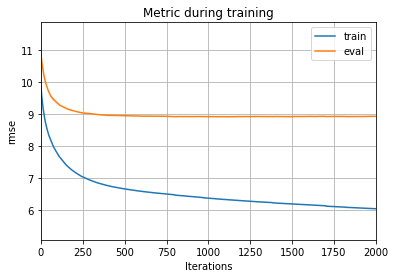

Plot feature importances...


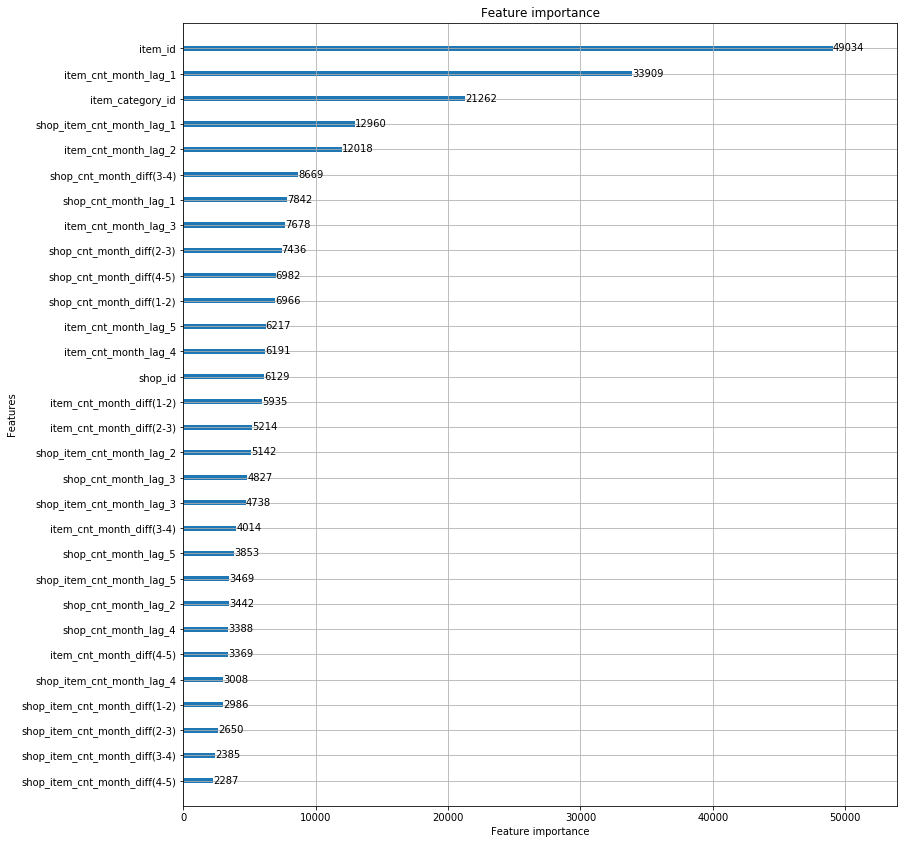

In [33]:
print('Plot metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
if(saveplots):plt.savefig("lgb_plot_metric_"+saveName+".pdf")
plt.show()

print('Plot feature importances...')
ax = lgb.plot_importance(model, max_num_features=x_test.shape[1])
ax.figure.set_size_inches(6.4*2,4.8*3)
if(saveplots):plt.savefig("lgb_plot_importance_"+saveName+".pdf")
plt.show()

In [34]:
pred_lgb = model.predict(x_train)
print('Training R-squared for LightGBM is %f' % r2_score(y_train, pred_lgb))

Training R-squared for LightGBM is 0.631545


In [35]:
pred_lgb = model.predict(x_val)
print('Validation R-squared for LightGBM is %f' % r2_score(y_val, pred_lgb))

Validation R-squared for LightGBM is 0.336467


# Predict with test data

In [36]:
pred_submit = model.predict(x_test)

In [37]:
print pred_submit.size
print pred_submit

214200
[1.68750425 1.80463112 1.33101763 ... 1.39801288 1.29062015 1.50681894]


In [38]:
# True target values are clipped into [0,20] range.
pred_submit = np.clip(pred_submit,0,20)
print pred_submit

[1.68750425 1.80463112 1.33101763 ... 1.39801288 1.29062015 1.50681894]


# Validation with yearly trend

total sales count from Oct10-2018_1 prediction: 285663.7958448925
total sales count from contant 0.5 prediction: 107100.0


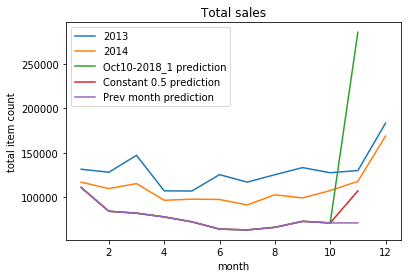

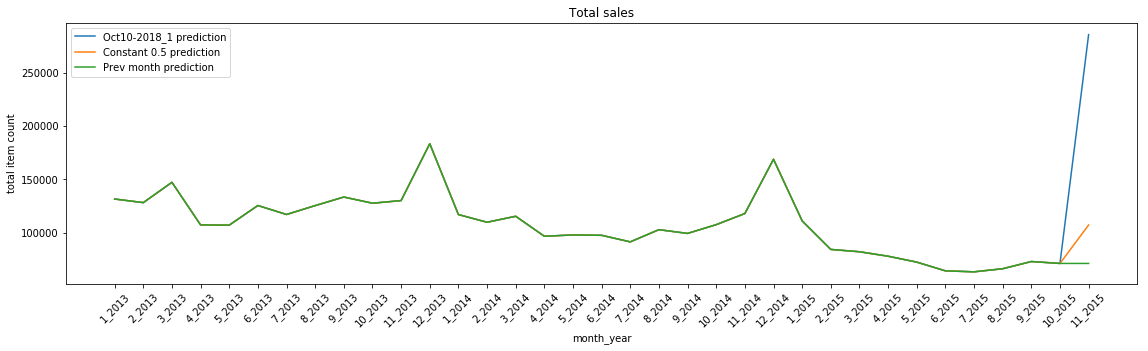

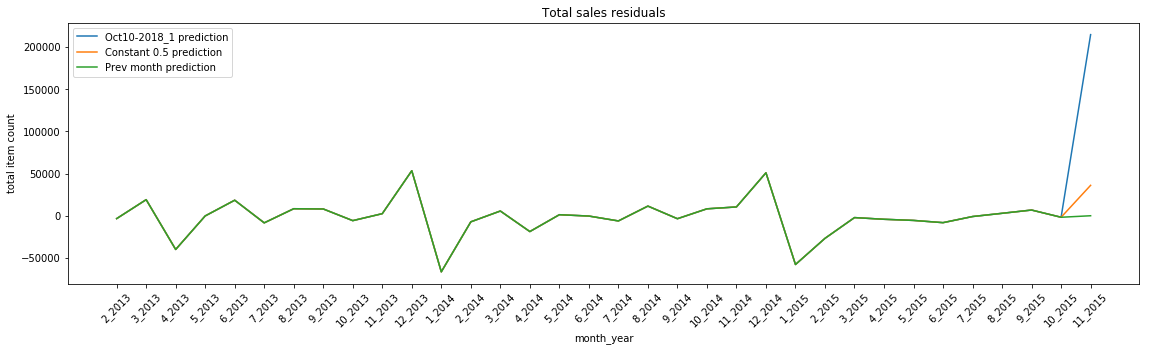

In [39]:
#import sys
#WorkDir = '/Users/rizki/Dropbox/Coursera/AML_HowToKaggle/FinalProject/PredictSales/'
#sys.path.insert(0, WorkDir)
import utility.utility as ut

y_test = pd.DataFrame(pred_submit,columns=['item_cnt_month'])
#saveName='constant_0p38'
#saveplots=True

total_item_cnt_2013 = sales_2013.groupby(['date_block_num','Y_M'])['item_cnt_day'].sum().values
total_item_cnt_2014 = sales_2014.groupby(['date_block_num','Y_M'])['item_cnt_day'].sum().values
total_item_cnt_2015 = sales_2015.groupby(['date_block_num','Y_M'])['item_cnt_day'].sum().values
yearlySales = [total_item_cnt_2013,total_item_cnt_2014,total_item_cnt_2015]

ut.plotYearly(yearlySales,y_test,saveName,saveplots)
ut.plotYearly_v2(yearlySales,y_test,saveName,saveplots)
ut.plotResidual(yearlySales,y_test,saveName,saveplots)

# Prepare submission file

In [41]:
test_sorted = test.sort_values(by=groupby_list).reset_index(drop=True)
submit = pd.concat([test_sorted,y_test],axis=1)
submit = submit.sort_values(by="ID").reset_index(drop=True)

# sanity check
print 'These numbers below should match:'
print 'y_test.iloc[0] =',y_test.iloc[0].values[0] 
print 'submit[submit["ID"]==22987] = ',submit[submit["ID"]==22987]["item_cnt_month"].values[0]

submit = submit[["item_cnt_month"]]
submit.index.name="ID"
submit.head()

submitName=''
if submitName=='': 
    submitName=saveName
if(createSubmit):submit.to_csv('submit_'+submitName+'.csv')

These numbers below should match:
y_test.iloc[0] = 1.6875042528727395
submit[submit["ID"]==22987] =  1.6875042528727395
